In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
import tqdm
from matplotlib.pyplot import figure
%matplotlib inline

## Parameters

In [2]:
epochs = 10
dense_rlambda = 1e-4
dense_lr = 1e-4
dropout_p = 0.2
norm_epsilon = 1e-4
training_epsilon = 1e-3
net_list = [784, 10]
drop = False
# Must be true if no hidden layer in net_list
last_relu = True
br = False

## Classes

In [3]:
# One-hot encoder for MNIST
class OneHotEncoder:
    
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [4]:
# Fully connected layer
class Dense:
    
    def __init__(self, in_size, out_size):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2 / in_size)
        self.b = np.zeros(out_size)
        self.rlambda = dense_rlambda
        
    def forward(self, x):
        # Remember x for a backward pass
        self.x = x
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz):
        # Calculate gradients by parameters (remember them for debugging)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # Calculate the input derivative
        self.dx = np.matmul(dz, self.W) 
        # Calculate the gradients from the regularizer
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # Update weights
        self.W = self.W - dense_lr * self.dW
        self.b = self.b - dense_lr * self.db
        # Return dx to continue the algorithm
        return self.dx

In [5]:
# Rectified linear unit
class ReLU:
    
    def forward(self, x):
        # Remember x for a backward pass
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz):
        dz[self.x < 0] = 0
        return dz

In [6]:
# Normalized exponential function
class Softmax:
    
    def forward(self, x):
        self.x = x
        exps = np.exp(x)
        return exps / np.sum(exps)
    
    def backward(self, dz):
        sm = self.forward(self.x)
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm * self.lp
        return np.dot(dz, self.lp2)

In [7]:
# Measures the performance of a classification model
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -1. * np.sum(y_true * np.log(y_hat))
    
    def backward(self, dz):
        return -1. * dz * self.y_true / self.y_hat

In [8]:
# Regularization technique for reducing overfitting
class Dropout:
    def __init__(self):
        self.p = dropout_p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        if not self.train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = (np.random.rand(*x.shape) > self.p) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz):
        return dz * self.mask

### The definition of the network

In [9]:
class MnistNet:
    
    def __init__(self):
        for i in range(len(net_list) - 1):
            exec("self.d{0} = Dense({1}, {2})".format(i, net_list[i], net_list[i + 1]))
            if last_relu and i == len(net_list) - 2:
                exec("self.m{0} = ReLU()".format(i))
            if i < len(net_list) - 2:
                exec("self.m{0} = ReLU()".format(i))
                if drop: 
                    exec("self.do%s = Dropout()" % i)
        self.s = Softmax()
    
    def forward(self, x):
        net = self.d0.forward(x)
        net = self.m0.forward(net)
        if drop:
            net = self.do0.forward(net)
        for i in range(len(net_list) - 2):
            net = eval("self.d{0}.forward(net)".format(i + 1))
            if last_relu and i == len(net_list) - 3:
                net = eval("self.m{0}.forward(net)".format(i + 1))
            if i < len(net_list) - 3:
                net = eval("self.m{0}.forward(net)".format(i + 1))
                if drop: 
                    net = eval("self.do{0}.forward(net)".format(i + 1))
        net = self.s.forward(net)
        return net
    
    def backward(self, dz):
        dz = self.s.backward(dz)
        for i in range(len(net_list) - 1):
            if drop and i > 0:
                dz = eval("self.do{0}.backward(dz)".format(len(net_list) - (i + 2)))
            if i > 0:
                dz = eval("self.m{0}.backward(dz)".format(len(net_list) - (i + 2)))
            if last_relu and i == 0:
                dz = eval("self.m{0}.backward(dz)".format(len(net_list) - (i + 2)))
            dz = eval("self.d{0}.backward(dz)".format(len(net_list) - (i + 2)))
        return dz

## Functions

In [10]:
def data_normalization(data):
    #data = data.astype('float')
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / (std + norm_epsilon), mean, std

In [11]:
def test_data_normalization(data, mean, std):
    #data = data.astype('float')
    return (data - mean) / (std + norm_epsilon)

In [12]:
# BE CAREFUL: Y_test in the non-one-hot format
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [13]:
def make_submission(X_test, net, fname="submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

## Main code block

In [14]:
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))
X_test_no_lab = test_data['data']

In [15]:
# Normalization of the input data and getting values for test dataset normalization
X_train, X_mean, X_std = data_normalization(X_train)

In [16]:
# Splitting data on the training and the test samples
X_train, X_test, Y_train, Y_test, Y_train_noh, Y_test_noh \
= train_test_split(X_train, Y_train_oh, Y_train, random_state=10, stratify=Y_train)

In [ ]:
# Initialization of objects
net = MnistNet()
loss = CrossEntropy()
L_train, L_test, A_train, A_test = [], [], [], []

In [ ]:
# Training
for iter in tqdm.tqdm_notebook(range(epochs)):
    L_acc = 0.
    sh = list(range(X_train.shape[0]))
    np.random.shuffle(sh)
    for i in range(X_train.shape[0]):
        x = X_train[sh[i]]
        y = Y_train[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_acc += L 
        dz = loss.backward(1.)
        dz = net.backward(dz)
    L_acc /= Y_train.shape[0]
    L_train.append(L_acc)
    L_e_acc = 0.
    for i in range(X_test.shape[0]):
        x = X_test[i]
        y = Y_test[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_e_acc += L
    L_e_acc /= Y_test.shape[0]
    L_test.append(L_e_acc)
    A_acc = compute_acc(X_train, Y_train_noh, net)
    A_e_acc = compute_acc(X_test, Y_test_noh, net)
    A_test.append(A_e_acc)
    A_train.append(A_acc)
    print("{}\titer.\nLoss:\ttrain:\t{}\ttest:\t{}.\nAccuracy:\ttrain:\t{}\ttest:\t{}.".format(iter, L_acc, L_e_acc, A_acc, A_e_acc))

0	iter.
Loss:	train:	0.8545831893356097	test:	0.4609682811503806.
Accuracy:	train:	0.8723555555555556	test:	0.8685714285714285.
1	iter.
Loss:	train:	0.4036046265220825	test:	0.38104216437297567.
Accuracy:	train:	0.8943492063492063	test:	0.8908952380952381.
2	iter.
Loss:	train:	0.35715251319716956	test:	0.3535568710157005.
Accuracy:	train:	0.9025269841269842	test:	0.8960761904761905.
3	iter.
Loss:	train:	0.33546314548048495	test:	0.3386086350092767.
Accuracy:	train:	0.9067174603174604	test:	0.9004952380952381.
4	iter.
Loss:	train:	0.3218684144517168	test:	0.32858645320015284.
Accuracy:	train:	0.9112126984126984	test:	0.904.
5	iter.
Loss:	train:	0.3123362886864589	test:	0.32246915999745307.
Accuracy:	train:	0.9126095238095238	test:	0.9068952380952381.
6	iter.
Loss:	train:	0.30485793362224733	test:	0.31679243847445065.
Accuracy:	train:	0.9155301587301587	test:	0.9093333333333333.
7	iter.
Loss:	train:	0.29923698933646026	test:	0.3134546293953406.
Accuracy:	train:	0.9165460317460318	test:	0

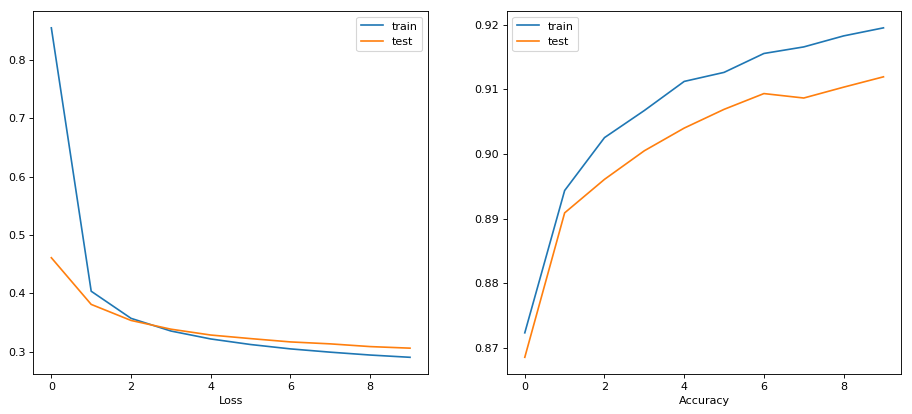

In [17]:
# Plotting cross-entropy loss and accuracy 
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
plt.plot(L_train, label="train")
plt.plot(L_test, label="test")
plt.xlabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(A_train, label='train')
plt.plot(A_test, label='test')
plt.xlabel('Accuracy')
plt.legend()

In [18]:
# Submission creation
X_test_norm = test_data_normalization(X_test_no_lab, X_mean, X_std)
make_submission(X_test_norm, net)